#### Задача классификации

По исходным признакам спрогнозировать отказ клиента от услуг банка. Построить модель с оптимальной операционной кривой (ROC). Целевая метрика — площадь под операционной кривой (ROC AUC).

#### Импорт библиотек и настройки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import xgboost
from xgboost import XGBClassifier
import optuna
from pickle import dump

In [2]:
plt.style.use('dark_background')

In [3]:
tableau_palette = [*colors.TABLEAU_COLORS.values()]

#### Описание и загрузка данных

Расшифровка полей в датасете:

- UserId — номер клиента
- CreditScore — кредитный рейтинг
- City — филиал банка
- Gender — пол клиента
- Age — возраст клиента
- Tenure — лет в банке
- Balance — баланс клиента
- NumOfProducts — подключенных продуктов
- HasCredit — наличие кридита
- IsActiveUser — активность клиента
- EstimatedSalary — предполагамая зарплата
- Exited — отказ от услуг (0 — нет, 1 — да)

In [4]:
train_df = pd.read_csv('data/train.csv')

In [5]:
train_df.head()

,UserId,CreditScore,City,Gender,Age,Tenure,Balance,NumOfProducts,HasCredit,IsActiveUser,EstimatedSalary,Exited
0,15674932,668,Москва,Мужчина,33.0,3,0.0,2,Да,Нет,90725.0,0
1,15749177,627,Москва,Мужчина,33.0,1,0.0,2,Да,Да,24752.0,0
2,15694510,678,Москва,Мужчина,40.0,10,0.0,2,Да,Нет,92433.0,0
3,15741417,581,Москва,Мужчина,34.0,2,1488825.0,1,Да,Да,42280.0,0
4,15766172,716,Новосибирск,Мужчина,33.0,5,0.0,2,Да,Да,7534.0,0


In [6]:
train_df.duplicated().sum()

37

In [7]:
train_df.drop_duplicates(inplace=True)

In [8]:
pd.DataFrame({'count': train_df.count(), 'isna': train_df.isna().sum(), 'nunique': train_df.nunique(), 'dtypes': train_df.dtypes})

,count,isna,nunique,dtypes
UserId,164997,0,23221,int64
CreditScore,164997,0,457,int64
City,164997,0,3,object
Gender,164997,0,2,object
Age,164997,0,71,float64
Tenure,164997,0,11,int64
Balance,164997,0,24614,float64
NumOfProducts,164997,0,4,int64
HasCredit,164997,0,2,object
IsActiveUser,164997,0,2,object


Помимо целевой переменной в наборе данных есть 11 признаков. Из них 7 — числовые, причем Tenure и NumOfProducts — числовые дискретные, которые при необходимости можно расматривать как порядковые категориальные. Остальные 4 признака — номинальные категориальные. Пропущенных значений нет ни в одном из признаков.

#### Разведочный анализ

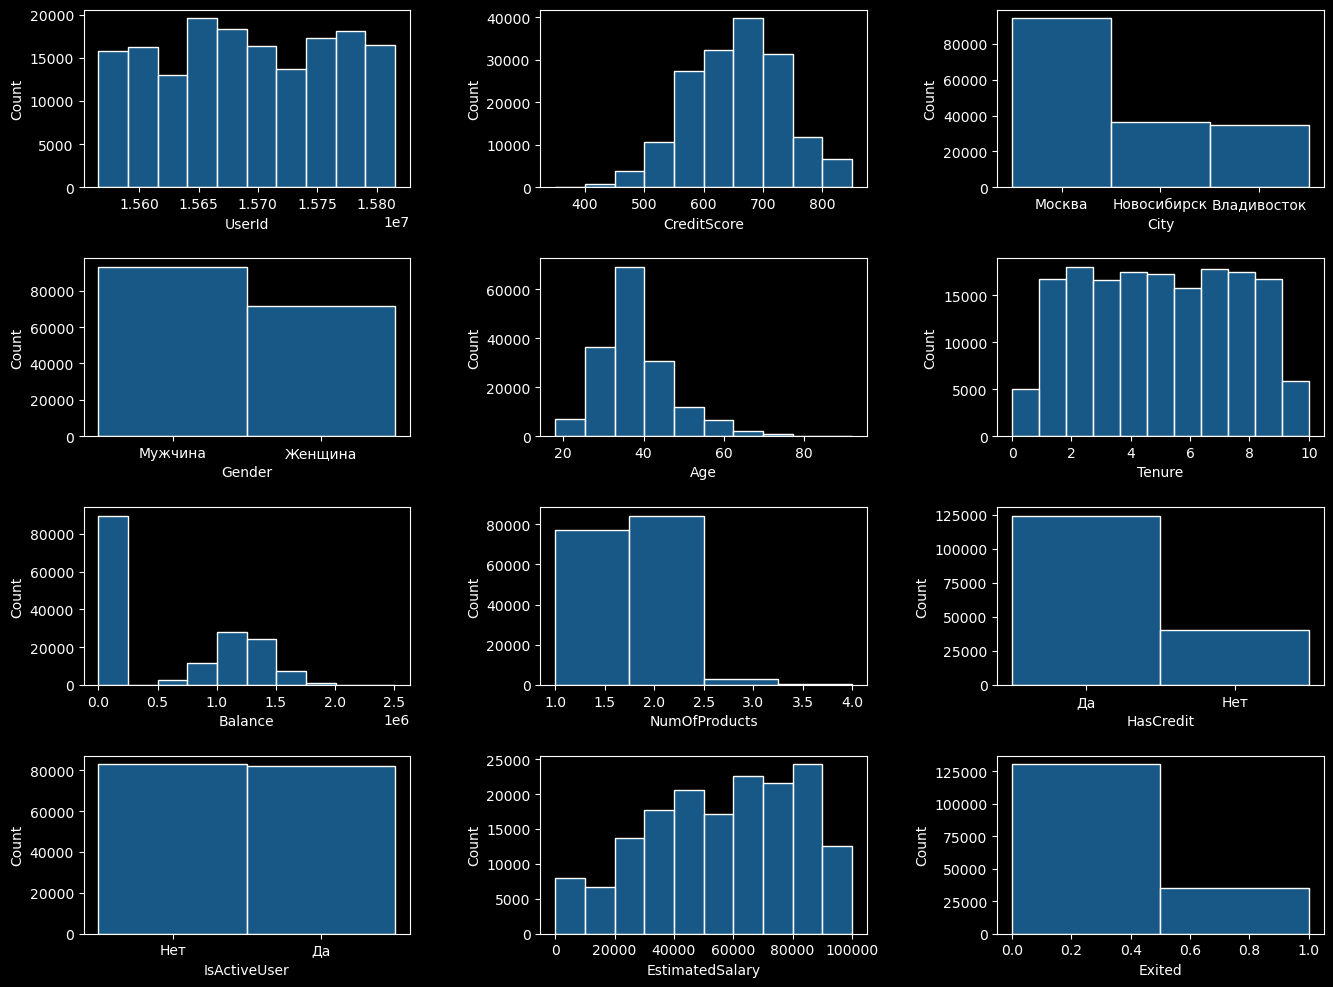

In [9]:
plt.figure(figsize=(16, 12)).subplots_adjust(wspace=0.4, hspace=0.4)
for i, column in enumerate(train_df.columns):
    nunique = train_df[column].nunique()
    bins = 10 if nunique > 11 else nunique
    sns.histplot(data=train_df, x=column, bins=bins, color='tab:blue', ax=plt.subplot(4, 3, i + 1))

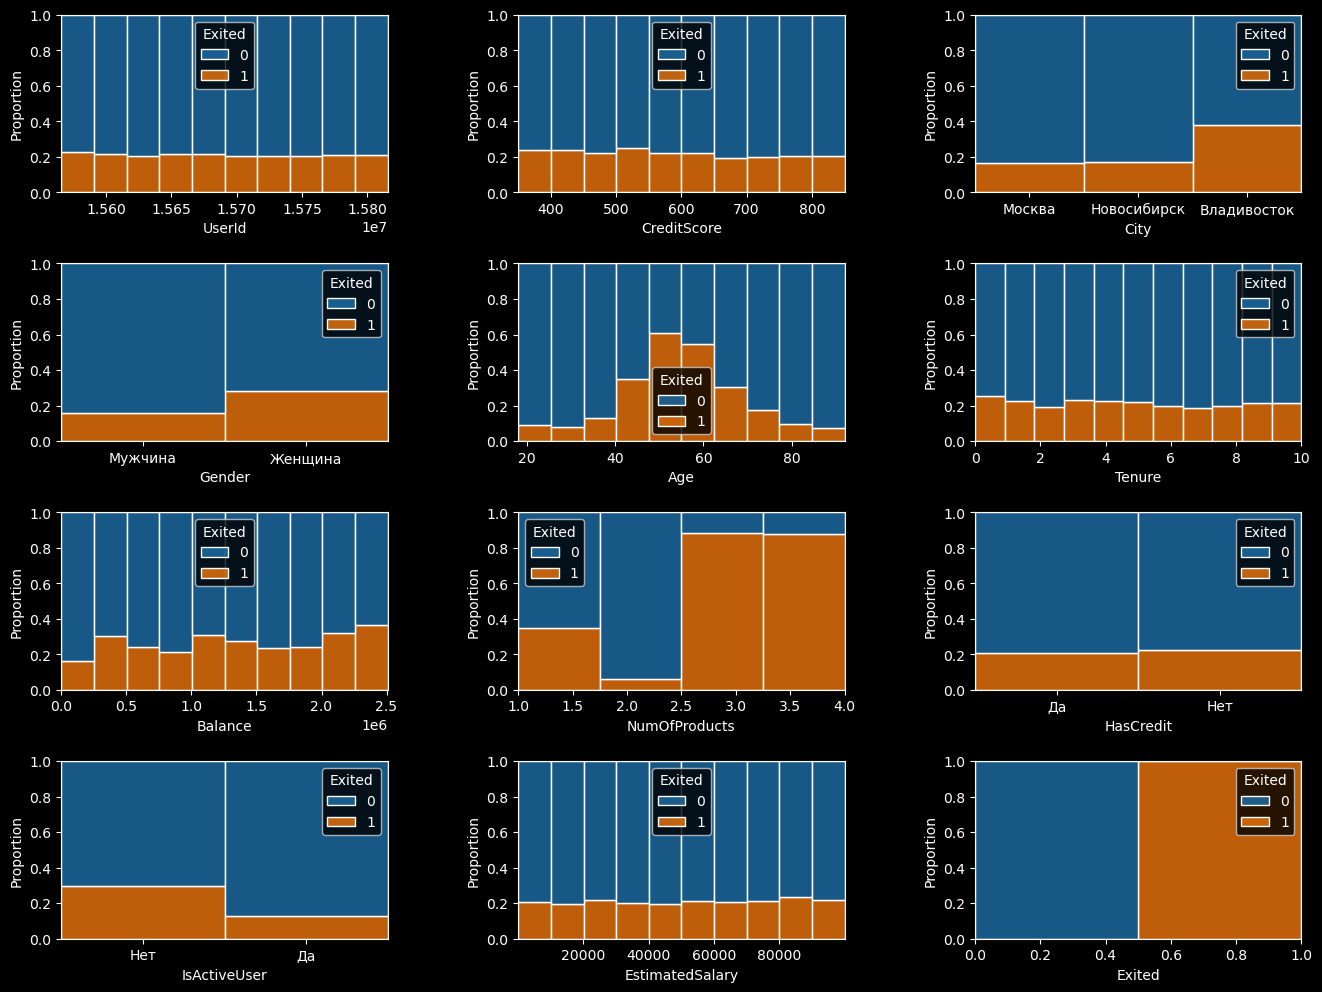

In [10]:
plt.figure(figsize=(16, 12)).subplots_adjust(wspace=0.4, hspace=0.4)
for i, column in enumerate(train_df.columns):
    nunique = train_df[column].nunique()
    bins = 10 if nunique > 11 else nunique
    sns.histplot(data=train_df, x=column, bins=bins, hue='Exited', hue_order=[0, 1], stat='proportion', multiple='fill', palette=['tab:blue', 'tab:orange'], ax=plt.subplot(4, 3, i + 1))

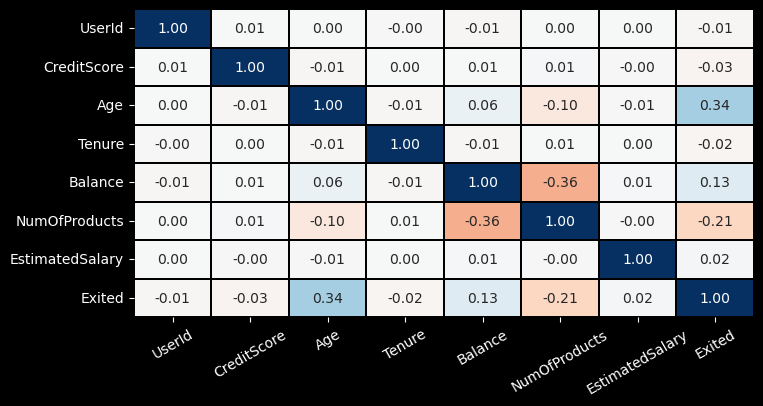

In [11]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=train_df.corr(numeric_only=True), vmin=-1, vmax=1, cmap='RdBu', cbar=False, annot=True, fmt='.2f', linecolor='k', linewidth=0.2)
_ = ax.tick_params(axis='x', labelrotation=30)

Чаще от услуг банка отказываются клиенты:

- Во Владивостоке
- Женщины
- В возрасте от 40 до 70 лет
- С большим количеством продуктов
- Неактивные
- С большим балансом

#### Обучение модели

Предварительная базовая модель подтвердила результаты разведочного анализа: в датасете есть признаки, которые не влияют на целевую метрику, их можно удалить. Неинформативные признаки: HasCredit, CreditScore, EstimatedSalary, UserId, Tenure. Добавление новых признаков не повышает качество модели.

In [12]:
X = train_df.drop(['Exited', 'HasCredit', 'CreditScore', 'EstimatedSalary', 'UserId', 'Tenure'], axis=1)

In [13]:
y = train_df.Exited

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Деревья решений — это нелинейные модели, поэтому для кодировки категориальных признаков возьмем Ordinal Encoder, а не One Hot Encoder, который увеличивает размерность датасета.

In [15]:
categorical_columns = X.select_dtypes(include='object').columns

In [16]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [17]:
column_transformer = ColumnTransformer(
    transformers=[('categorical', ordinal_encoder, categorical_columns)],
    remainder='passthrough',
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
).set_output(transform='pandas')

In [18]:
dtrain = xgboost.DMatrix(data=column_transformer.fit_transform(X_train), label=y_train)

In [19]:
def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.05, 0.30, step=0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100, step=1),
        'subsample': trial.suggest_float('subsample', 0.50, 1.00, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.50, 1.00, step=0.05),
        'lambda': trial.suggest_float('lambda', 0.01, 100.00, log=True),
    }
    params['objective'] = 'binary:logistic'
    params['tree_method'] = 'hist'
    cv = xgboost.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        nfold=5,
        stratified=True,
        seed=0,
        metrics='auc',
    )
    return cv.iloc[-1]['test-auc-mean']

In [20]:
study = optuna.create_study(study_name='optuna_study', direction='maximize')

[I 2025-02-01 15:54:28,472] A new study created in memory with name: optuna_study


In [21]:
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-02-01 15:55:05,075] Trial 3 finished with value: 0.8878568680664044 and parameters: {'eta': 0.15000000000000002, 'max_depth': 7, 'min_child_weight': 60, 'subsample': 0.6, 'colsample_bytree': 1.0, 'lambda': 16.370883787627978}. Best is trial 3 with value: 0.8878568680664044.
[I 2025-02-01 15:55:15,315] Trial 2 finished with value: 0.8879114611320125 and parameters: {'eta': 0.1, 'max_depth': 8, 'min_child_weight': 51, 'subsample': 0.75, 'colsample_bytree': 0.95, 'lambda': 2.460177308002711}. Best is trial 2 with value: 0.8879114611320125.
[I 2025-02-01 15:55:16,168] Trial 0 finished with value: 0.8883184246078949 and parameters: {'eta': 0.15000000000000002, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'lambda': 1.332558036820611}. Best is trial 0 with value: 0.8883184246078949.
[I 2025-02-01 15:55:41,700] Trial 1 finished with value: 0.888238919926488 and parameters: {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 29, 'subsamp

In [22]:
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['tree_method'] = 'hist'
best_params

{'eta': 0.15000000000000002,
 'max_depth': 4,
 'min_child_weight': 6,
 'subsample': 0.75,
 'colsample_bytree': 0.8500000000000001,
 'lambda': 1.332558036820611,
 'objective': 'binary:logistic',
 'tree_method': 'hist'}

In [23]:
cv = xgboost.cv(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    nfold=5,
    stratified=True,
    seed=0,
    metrics='auc',
)

In [24]:
cv.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
87,0.891001,0.000558,0.888297,0.002232
88,0.891017,0.000557,0.888301,0.002240
89,0.891029,0.000558,0.888293,0.002244
90,0.891068,0.000558,0.888312,0.002237
91,0.891098,0.000555,0.888318,0.002243


In [25]:
best_round = len(cv)
best_round

92

In [26]:
classifier = XGBClassifier(**{
    'n_estimators': best_round,
    'learning_rate': best_params['eta'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['lambda'],
    'objective': best_params['objective'],
    'tree_method': best_params['tree_method'],
})

In [27]:
pipe = Pipeline([
    ('column_transformer', column_transformer),
    ('classifier', classifier),
])

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['City', 'Gender', 'IsActiveUser'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier(base_score=None, booster...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.15000000000000002, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=92, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [29]:
roc_auc_score(y_true=y_train, y_score=pipe.predict_proba(X_train)[:, 1])

0.8907991511251818

In [30]:
roc_auc_score(y_true=y_test, y_score=pipe.predict_proba(X_test)[:, 1])

0.8875475073962562

Площадь под кривой (ROC AUC) на тестовом наборе незначительно ниже, чем на тренировочном, значит, модель не переобучена.

In [31]:
feature_importances = pd.DataFrame({
    'feature': classifier.get_booster().get_score(importance_type='gain').keys(),
    'importance': classifier.get_booster().get_score(importance_type='gain').values(),
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [32]:
feature_importances

,feature,importance
0,NumOfProducts,318.475006
1,Age,133.782669
2,IsActiveUser,129.004807
3,City,78.317268
4,Gender,45.084099
5,Balance,23.319016


#### Анализ результатов

In [33]:
y_cv = cross_val_predict(estimator=pipe, X=X, y=y, n_jobs=-1, method='predict_proba')

In [34]:
y_cv = y_cv[:, 1]

In [35]:
fpr, tpr, thresholds = roc_curve(y, y_cv)

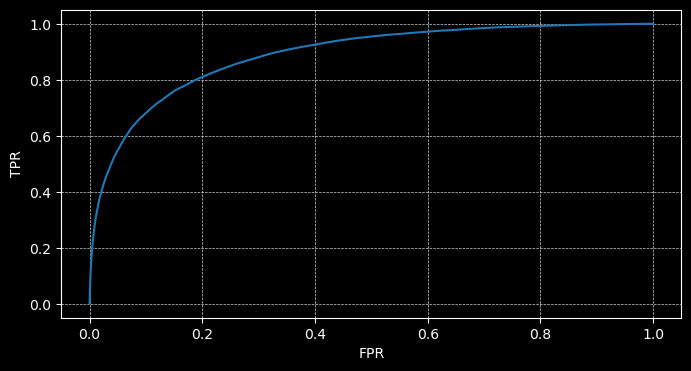

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr, tpr, color='tab:blue')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(axis='both', color='lightgray', linestyle='dashed', linewidth=0.5)

В качестве операционной точки можно выбрать уровень True Positive Rate (TPR) в районе 0,80. Дальнейшее увеличение TPR приведет к значительному росту False Positive Rate (FPR).

Чтобы выбрать оптимальную операционную точку, необходимы новые вводные. Например, стоимость привлечения нового клиента и стоимость удержания старого.

In [37]:
idx = np.argmin(np.abs(tpr - 0.80))

In [38]:
tpr[idx]

0.7999942716388841

In [39]:
fpr[idx]

0.18849503778356896

In [40]:
thresholds[idx]

0.20488289

TPR на уровне 0,80 соответствует значению FPR в районе 0,19 при уровнне Threshold около 0,20.

In [41]:
cm = confusion_matrix(y, y_cv >= thresholds[idx])

In [42]:
labels = ['Not Exited (0)', 'Exited (1)']

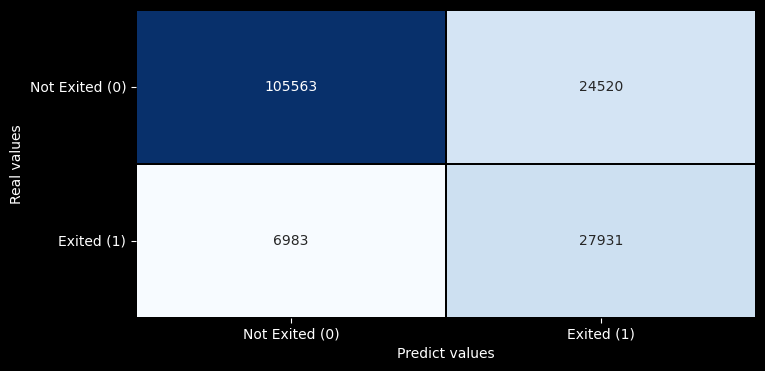

In [43]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g', cmap='Blues', cbar=False, linecolor='k', linewidth=0.2)
ax.set_ylabel('Real values')
ax.set_xlabel('Predict values')
_ = ax.tick_params(labelrotation=0)

Сохраним результаты кросс-валидации и модель для дашборда.

In [44]:
cv_df = pd.DataFrame({'y_true': y, 'y_pred': y_cv})

In [45]:
cv_df.head()

,y_true,y_pred
0,0,0.018467
1,0,0.008681
2,0,0.037806
3,0,0.038675
4,0,0.008902


In [46]:
cv_df.to_csv('data/preds.csv', index=False)

In [47]:
pipe.fit(X, y)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['City', 'Gender', 'IsActiveUser'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier(base_score=None, booster...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.15000000000000002, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=92, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [48]:
with open('data/model.pkl', 'wb') as f:
    dump(pipe, f, protocol=5)